## Загрузка данных и подготовка к анализу

### Загрузка данных

In [1]:
# импортируем библиотеки
import pandas as pd
import datetime as dt

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import transforms

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.simplefilter('ignore')
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [2]:
# задаем настройки отображения
sns.set()
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# загружаем дата-сет
data = pd.read_csv('/datasets/gym_churn.csv')

In [4]:
# фунция для получения общей информации о датасетах
def get_info(df, df_name):
    print(f'Общая информация о таблице - {df_name}')
    display(df.head(10)) # выводим "голову" таблицы
    print('*'*50)
    print(df.info() , '\n') # общую информацию
    print('*'*50)
    print(df.columns, '\n') # названия столбцов
    print('*'*50)
    print(f'Количество NaN значений в таблице - {df_name}', '\n') 
    print(df.isna().sum()) # количество пропусков
    print('*'*50)
    print(f'Число дубликатов в таблице - {df_name}', '\n') 
    print(df.duplicated().sum()) # количество дубликатов

In [5]:
# вызываем функцию
get_info(data, 'gym_churn')

Общая информация о таблице - gym_churn


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0
5,1,1,0,0,1,1,1,34,450.74,1.00,3,2.62,2.64,0
6,1,1,1,1,0,6,1,32,94.27,6.00,2,1.14,1.28,0
7,0,1,0,0,1,1,0,30,217.79,1.00,0,1.21,1.05,1
8,1,1,1,1,1,1,1,23,45.41,1.00,1,1.11,1.06,0
9,0,1,0,0,1,1,0,31,65.31,1.00,11,1.81,1.95,0


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_c

###  Вывод о загрузке данных¶

В таблице 14 столбцов:

* float64 - 4 столбца
* int64 - 10 столбцов

Согласно документации к данным:

Каждая запись в логе — информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента.

Таблица содержит 4000 строк, не имеет пропусков и дубликатов. При изучении общей информации обнружены следующие проблемы:

* Смешаный регистр в заголовках
* month_to_end_contract в виде float64

В предобработке данных:

* правим заголовки
* меняем формат

### Предобработка данных

In [6]:
data['Contract_period'].unique()

array([ 6, 12,  1])

Три типа абонементов.

In [7]:
# приведём названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()
data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [8]:
# приведем месяцы до конца контракта к целочисленному формату
data['month_to_end_contract'] = data['month_to_end_contract'].astype(np.int64)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

### Вывод о предобработке

* названия колонок в snake_case
* месяцы приведены в целочисленный формат

## Исследовательский анализ данных (EDA)

### Ищем отсутствующие признаки, изучаем средние значения и стандартные отклонения

In [9]:
print('Описание признаков и целевой перменной:')
print(data.describe().T)

Описание признаков и целевой перменной:
                                     count   mean   std   min   25%    50%    75%    max
gender                            4,000.00   0.51  0.50  0.00  0.00   1.00   1.00   1.00
near_location                     4,000.00   0.85  0.36  0.00  1.00   1.00   1.00   1.00
partner                           4,000.00   0.49  0.50  0.00  0.00   0.00   1.00   1.00
promo_friends                     4,000.00   0.31  0.46  0.00  0.00   0.00   1.00   1.00
phone                             4,000.00   0.90  0.30  0.00  1.00   1.00   1.00   1.00
contract_period                   4,000.00   4.68  4.55  1.00  1.00   1.00   6.00  12.00
group_visits                      4,000.00   0.41  0.49  0.00  0.00   0.00   1.00   1.00
age                               4,000.00  29.18  3.26 18.00 27.00  29.00  31.00  41.00
avg_additional_charges_total      4,000.00 146.94 96.36  0.15 68.87 136.22 210.95 552.59
month_to_end_contract             4,000.00   4.32  4.19  1.00  1.00   

* распределение по полу примерно одинаково 
* большинство клиентов (84.5%) живет или работает рядом с фитнес-клубом
* примерно половина клиентов являются сотрудниками партнерских организаций
* около 30% клиентов пришли по программе "Приведи друга"
* известны мобильные номера примерно 90% клиентов
* средняя длительность абонемента клиентов - 4.6 месяца
* чуть более 40% клиентов посещают групповые занятия
* средний возраст клиентов 29 лет
* средние дополнительные расходы на клиента - 146.9 денег (наибольний разброс в данных, стандартное отклонение 96.35)
* средний срок до окончания договора - 4.3 месяца
* среднее время с момента первого обращения в фитнес-центр - 3.7 месяца
* средняя частота посещений за все время - 1.87 раз в неделю
* средняя частота посещений за последний месяц - 1.76 раз в неделю
* **доля оттока - 26.5%**

### Смотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [10]:
# сгруппируем данные по оттоку пользователей
data.groupby('churn').agg({'mean'}).T

,churn,0,1
gender,mean,0.51,0.51
near_location,mean,0.87,0.77
partner,mean,0.53,0.36
promo_friends,mean,0.35,0.18
phone,mean,0.90,0.90
contract_period,mean,5.75,1.73
group_visits,mean,0.46,0.27
age,mean,29.98,26.99
avg_additional_charges_total,mean,158.45,115.08
month_to_end_contract,mean,5.28,1.66


* различий по полу нет
* чаще остаются те, кто живет ближе 87% против 76%
* сотрудники компании-партёра клуба чаще остаются, что так же характерно, как и для рядом живущих/работающих
* клиенты, пришедшие по акции "Приведи друга" в два раза реже уходят в отток
* наличие мобильного номера клиента не отличается в группах
* оставшиеся пользователи покупают "долгие" абонементы (в среднем на полгода 5.74), у ушедших видим "короткие" абонементы (в среднем 1.72 - по описанию месячные и трехмесячные)
* оставшиеся пользователи почти в 2 раза чаще ходят на групповые занятия (хотя возможно, что в отток попали те, кто еще не успел начать ходить на них)
* средний возраст в группах различается, в группе оставшихся - 29.9, в группе ушедших - 26.9
* суммарная выручка от других услуг фитнес-центра немного различается, оставшиеся платят больше
* что характерно, у тех, кто остался больше месяцев до конца договора, чем у тех, кто ушел
* время с первого обращения частично повторяет для групп длительность абонемента: у оставшихся - 4.7, у ушедших 0.99
* средняя частота посещений в неделю за все время с начала действия абонемента у ушедших несколько ниже
* средняя частота посещений в неделю за предыдущий месяц у ушедших ниже в 2 раза

На первый взгляд факторами оттока являются:

* отсутствие специальных льготных условий обслуживания: компания-партнер или акция "приведи друга";
* приобретение абонемента на минимальный период;
* низкая посещаемость групповых занятий;
* 1,5-разовое посещение фитнес-центра в неделю за все время с начала действия абонемента и лишь разовое  в неделю в течение последнего месяца.

### Гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [11]:
# переименовываем столбцы для отрисовки
data_to_plot = data.rename(columns={
    'gender' : 'Пол',
    'near_location' : 'Проживание в районе фитнес-центра',
    'partner' : 'Сотрудник компании-партнера',
    'promo_friends' : 'Акция "Приведи друга"',
    'phone' : 'Телефон',
    'contract_period' : 'Текущий абонемент',
    'group_visits' : 'Групповые занятия',
    'age' :  'Возраст',
    'avg_additional_charges_total' : 'Выручка от прочих услуг',
    'month_to_end_contract' : 'Срок окончания абонемента',
    'lifetime' : 'Лайфтайм',
    'avg_class_frequency_total' : 'Средняя частота посещений в неделю с начала действия абонемента',
    'avg_class_frequency_current_month' :  'Средняя частота посещений в неделю за месяц',
    'churn' : 'Отток'                
            })

# получаем список столбцов
columns_to_plot=data_to_plot.columns.to_list()


# поправим значения в целевой колонке
data_to_plot = data_to_plot.replace({'Отток':{0 : 'Группа лояльных клиентов', 1 : 'Группа оттока'}})

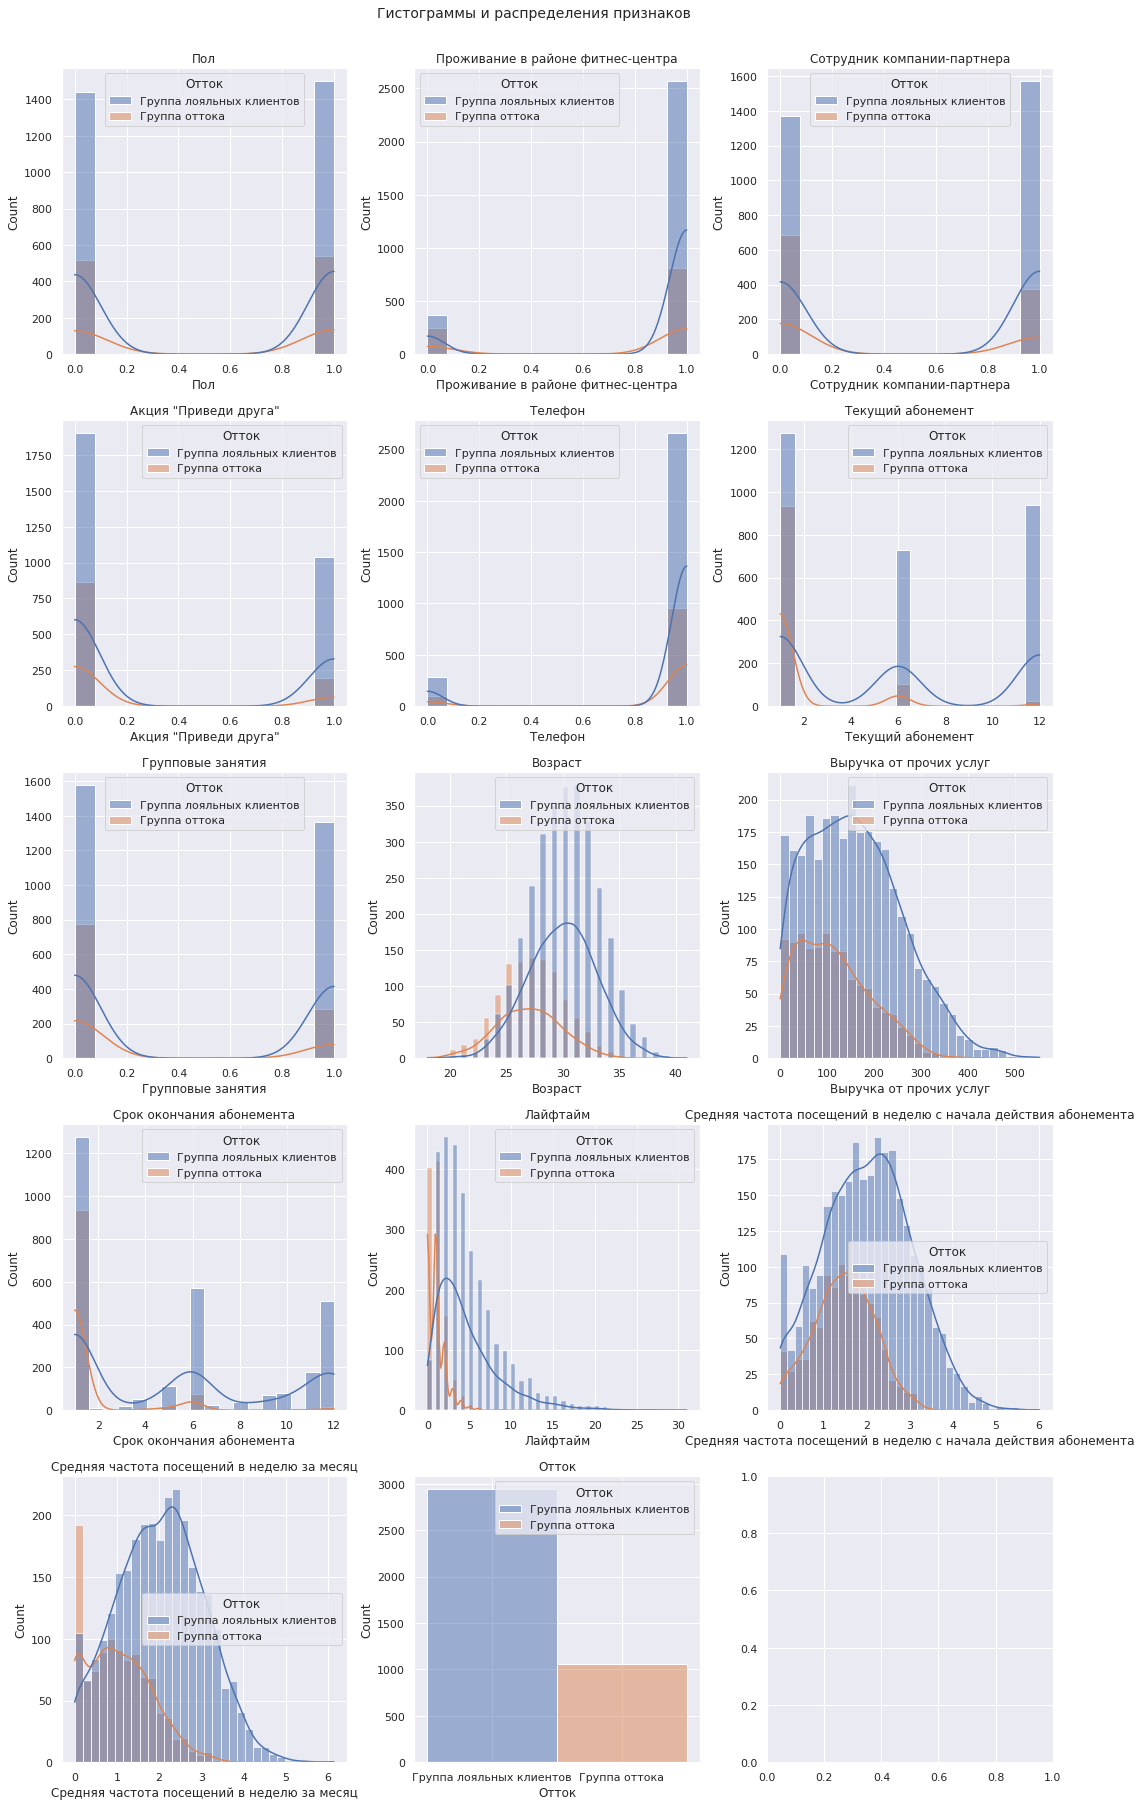

In [12]:
# рисуем гистограммы и распределения
# зададим параметры сетки
WIDTH = 3
plot_amount = len(data_to_plot.columns)
height = plot_amount//WIDTH + 1

# расположение графиков в сетке
fig, axs = plt.subplots(height, WIDTH, figsize=(15, 25))
fig.suptitle('Гистограммы и распределения признаков',  y=1.003, size=14) # общий заголовок

# напишем цикл, который нарисует гистограмму к каждому признаку из таблицы в заданной сетке
for item, ax in zip(data_to_plot.columns, np.ravel(axs)): # выбираем признак, положение и сводим положение к одномерному массиву
    sns.histplot(data = data_to_plot, x=item, hue='Отток', ax=ax, kde=True) # рисуем гистограммы
    ax.set_title(item, size=12) # подписываем каждый график признаком

plt.tight_layout() # ограничим заголовки графиков сеткой
plt.show()

Гистограммы наглядно демострируют данные из таблицы и подкрепляют выводы полученные из анализа средних значений.

* видим, что в группе оттока в основном берут абонемент на месяц, редко на полгода и почти никогда на год
* групповые занятия в целом чаще не посещают, чем посещают. Доля оттока среди посещающих групповые занятия значительно меньше доли оттока среди непосещающих групповые занятия
* чуть больше 200 человек, у которых не был зафиксирован факт оттока воспользовались дополнительными услугами фитнес центра и принесли выручку в районе 200 денег с человека 
* срок до окончания текущего абонемента у группы оттока составляет, в основном, 1 месяц.
* лайфтайм лояльных клиентов постепенно снижается после полугода, тогда как в группе оттока он резко обрывается после 1 месяца "жизни".
* лояльные клиенты в среднем посещают фитнес-центр 2-3 раза в неделю, у ушедших преобладает 1-2 посещения.
* за последний месяц клиенты из группы оттока практически не посещали занятия, оставшиеся так же ходят 2-3 раза в неделю.

Больше всего похоже на нормальное распределение - распределение по возрасту, при том в обеих группах.

### Матрицу корреляций

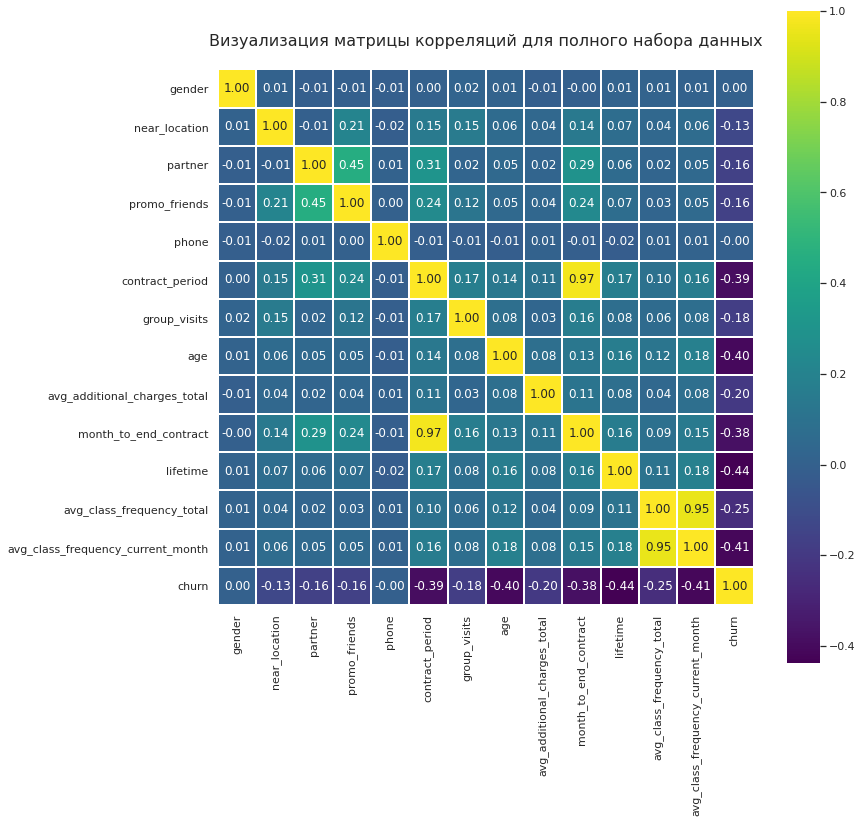

In [13]:
# посчитаем корелляцию в отдельную переменную
cor_data = data.corr()
# рисуем матрицу корреляций по основной таблице
# по data_to_plot работает не так из-за текстовых изменений в колонке оттока
plt.figure(figsize=(12,12))
sns.heatmap(cor_data, annot=True, square=True, fmt='0.2f', linewidths=1, cmap= 'viridis')
plt.title('Визуализация матрицы корреляций для полного набора данных\n', fontsize=16)
plt.show()

Величина коэффициента корреляции отражает силы связи. При оценке силы связи коэффициентов корреляции используется шкала Чеддока:

| Значение  | Интерпретация  |
|:-------------|:---------------|
|от 0 до 0,3 | очень слабая |
| от 0,3 до 0,5	| слабая        |
| от 0, 5 до 0,7 | средняя      |
| от 0,7 до 0, 9| высокая|
|от 0,9 до 1| очень высокая|

Видим наличие очень высокой положительной корреляции между переменными `текущим абонементом` и `сроком его окончания`, а также между переменными `средней частотой посещений в неделю с начала действия абонемента` и `средней частотой посещений в неделю за месяц`, что неудевительно, это взаимозависимые переменные.

Остальные корреляции слабые отрицательные между оттоком и:
* текущим абонементом
* возрастом
* сроком окончания абонемента
* лайфтаймом
* средней частотой посещений в неделю за предыдущий месяц

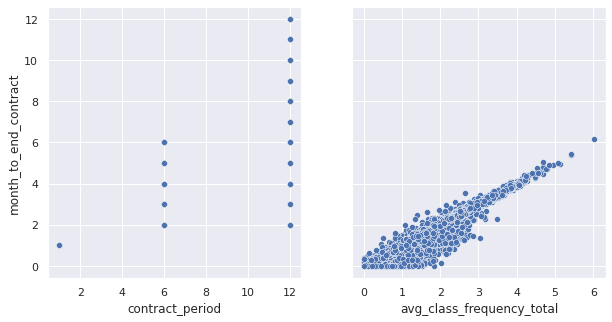

In [14]:
# построим попарные диаграммы рассеяния взаимозависимых признаков
fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
sns.scatterplot(data['contract_period'], data['month_to_end_contract'], ax = ax_1)
sns.scatterplot(data['avg_class_frequency_total'], data['avg_class_frequency_current_month'], ax = ax_2)
plt.show()

### Вывод (EDA)

**Средний образ пользователя:**

* средний возраст клиентов 29 лет, но зал посещают люди от 18 до 41 года и в гендерном соотношении разделены практически одинаково
* большинство клиентов (84.5%) живет или работает рядом с фитнес-клубом, примерно половина клиентов являются сотрудниками партнерских организаций, около 30% клиентов пришли по программе "Приведи друга", чуть более 40% клиентов посещают групповые занятия
* известны мобильные номера примерно 90% клиентов
* почти половина клиентов - сотрудники компании-партнёра клуба. Факт оттока в текущем месяце зафиксирован у 26% клиентов
* в текущем месяце был зафиксирован равномерный отток как мужчин, так и женщин, осталось тоже одинаковое соотношение полов
* средняя длительность абонемента клиентов - 4.6 месяца, средний срок до окончания договора - 4.3 месяца, среднее время с момента первого обращения в фитнес-центр - 3.7 месяца

**Распределения и отток пользователей:**

* наибольший разброс в данных наблюдается у показателя avg_additional_charges_total (стандартное отклонение 96.35), при этом среднее - 146.9 (суммарная выручка от дополнительных процедур в фитнес центре)
* больше всего похоже на нормальное распределение - распределение по возрасту, при том в обеих группах.
* в группе оттока в основном берут абонемент на месяц, редко на полгода и почти никогда на год
* групповые занятия в целом чаще не посещают, чем посещают. Доля оттока среди посещающих групповые занятия значительно меньше доли оттока среди непосещающих групповые занятия
* чуть больше 200 человек, у которых не был зафиксирован факт оттока воспользовались дополнительными услугами фитнес центра и принесли выручку в районе 200 денег с человека 
* срок до окончания текущего абонемента у группы оттока составляет, в основном, 1 месяц.
* лайфтайм лояльных клиентов постепенно снижается после полугода, тогда как в группе оттока он резко обрывается после 1 месяца "жизни".
* лояльные клиенты в среднем посещают фитнес-центр 2-3 раза в неделю, у ушедших преобладает 1-2 посещения.
* за последний месяц клиенты из группы оттока практически не посещали занятия, оставшиеся так же ходят 2-3 раза в неделю.

**Корелляции:** 
 
 
* все признаки имеют отрицательный знак корреляции. Следовательно, возрастание признака привведет к уменьшею оттока клиентов.
* наименьшее влияние на отток оказывают такие признаки как пол и телефон
* наибольшую отрицательную корреляцию показывают:длительность текущего абонемента, возраст, срок до окончания текущего действующего абонемента, лайфтайм и средняя частота посещений в неделю за предыдущий месяц
* имеется сильная связь между признаками длительности текущего абонемента и количеством месяцев до его окончания, между средней частотой посещений с начала использования абонемента и за прошедший месяц. Из проанализированных данных видно, что средняя длительность абонементов не велика, абонементы на 1 месяц самые востребованные, а на диаграмме рассеяния видна сильная зависимость между двумя признаками. Таким данные могут создавать шум в процессе обучения модели

## Модель прогнозирования оттока клиентов

In [15]:
# удаляем мультиколлинеарные  признаки
data_clean = data.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis=1)
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        4000 non-null   int64  
 1   near_location                 4000 non-null   int64  
 2   partner                       4000 non-null   int64  
 3   promo_friends                 4000 non-null   int64  
 4   phone                         4000 non-null   int64  
 5   contract_period               4000 non-null   int64  
 6   group_visits                  4000 non-null   int64  
 7   age                           4000 non-null   int64  
 8   avg_additional_charges_total  4000 non-null   float64
 9   lifetime                      4000 non-null   int64  
 10  avg_class_frequency_total     4000 non-null   float64
 11  churn                         4000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 375.1 KB


In [16]:
# выделим матрицу и целевую переменную
X = data_clean.drop('churn', axis=1)
y = data_clean['churn']

In [17]:
# разбьем данные на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [18]:
# задайте список моделей
models = [LogisticRegression(random_state=0, solver='liblinear'), 
          RandomForestClassifier(random_state=0, n_estimators = 100)]

# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Метрики при автоматическом прогнозе с помощью predict')
    print(
        'Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)),
          'Precision: {:.2f}\n'.format(precision_score(y_test, y_pred)),
          'Recall: {:.2f}\n'.format(recall_score(y_test, y_pred)),
          'F1: {:.2f}\n\n'.format(f1_score(y_test, y_pred))
        )
    

    # воспользуемся уже обученной моделью, чтобы сделать прогнозы
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # зададим порог
    threshold = 0.4

    # на основании вероятностей и соотношения классов перерассчитаем predict
    custom_pred = [0 if i < threshold else 1 for i in y_prob]

    # выведем метрики для прогноза по новому порогу
    print('Метрики для прогноза с кастомным порогом')
    print(
        'Accuracy: {:.2f}\n'.format(accuracy_score(y_test, custom_pred)),
          'Precision: {:.2f}\n'.format(precision_score(y_test, custom_pred)),
          'Recall: {:.2f}\n'.format(recall_score(y_test, custom_pred)),
          'F1: {:.2f}\n\n'.format(f1_score(y_test, custom_pred))
        )
    print() 

In [19]:
# напишем цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(m=i, X_train=X_train, y_train=y_train,
                    X_test=X_test, y_test=y_test)

LogisticRegression(random_state=0, solver='liblinear')
Метрики при автоматическом прогнозе с помощью predict
Accuracy: 0.88
 Precision: 0.76
 Recall: 0.77
 F1: 0.77


Метрики для прогноза с кастомным порогом
Accuracy: 0.88
 Precision: 0.72
 Recall: 0.82
 F1: 0.76



RandomForestClassifier(random_state=0)
Метрики при автоматическом прогнозе с помощью predict
Accuracy: 0.89
 Precision: 0.78
 Recall: 0.77
 F1: 0.78


Метрики для прогноза с кастомным порогом
Accuracy: 0.88
 Precision: 0.74
 Recall: 0.82
 F1: 0.78





Рассчет метрик показывает, что оба алгоритма способны давать прогнозы достаточно хорошо. Однако, модель логистической регрессии показывает чуть лучшие результаты по точности (precision) и полноте (recall), что подтсверждается в рассчетах метрики F1_score.

При изменении порога до 0,4 метрика полноты вырастает в обоих алгоритмах, а точность, наоборот, снижается. При этом F1 для логической регрессии падает, а для случайного леса растет.

In [20]:
# стандартизируем данные
# обучаем StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# преобразовываем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [21]:
# посмотрим как меняется модель на стандартизированных метриках
for i in models:
    print(i)
    make_prediction(m=i, X_train=X_train_st, y_train=y_train,
                    X_test=X_test_st, y_test=y_test)

LogisticRegression(random_state=0, solver='liblinear')
Метрики при автоматическом прогнозе с помощью predict
Accuracy: 0.90
 Precision: 0.79
 Recall: 0.81
 F1: 0.80


Метрики для прогноза с кастомным порогом
Accuracy: 0.89
 Precision: 0.74
 Recall: 0.83
 F1: 0.78



RandomForestClassifier(random_state=0)
Метрики при автоматическом прогнозе с помощью predict
Accuracy: 0.89
 Precision: 0.79
 Recall: 0.76
 F1: 0.77


Метрики для прогноза с кастомным порогом
Accuracy: 0.89
 Precision: 0.74
 Recall: 0.83
 F1: 0.78





**После стандартизации видим, что модель логистической регрессии ведет себя лучше на базовом пороге** на кастомном пороге обе модели выглядят **одинаково**. Ищем дальше.

In [22]:
# считаем вероятности для логистической регресии
# зададим алгоритм для нашей модели
log = LogisticRegression(random_state=0, solver='liblinear')

# обучим модель
log.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
log_pred = (log.predict_proba(X_test_st)[:,1]) # без порога
log_pred_t = (log.predict_proba(X_test_st)[:,1] >= 0.4) # задали порог 0.4

# выведем roc_auc_score
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, log_pred)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, log_pred_t)))

ROC_AUC: 0.95
ROC_AUC: 0.87


In [23]:
# считаем вероятности для случайного леса
# зададим алгоритм для нашей модели
forest = RandomForestClassifier(random_state=0, n_estimators = 100)

# обучим модель
forest.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
forest_pred = (forest.predict_proba(X_test_st)[:,1]) # без порога
forest_pred_t = (forest.predict_proba(X_test_st)[:,1] >= 0.4) # задали порог 0.4

# выведем roc_auc_score
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, forest_pred)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, forest_pred_t)))

ROC_AUC: 0.94
ROC_AUC: 0.87


На сравнении кривой ошибок тоже все примерно одинаково, оставим **случайный лес**

In [24]:
# оставляем лучшую модель
final_model = RandomForestClassifier(random_state=0, n_estimators = 100)
final_model.fit(X_train_st, y_train)
y_pred = final_model.predict(X_test)

In [25]:
fi_df = pd.DataFrame(
    data={'feature': X.columns, 'importance': final_model.feature_importances_}
)
print(fi_df.sort_values('importance', ascending=False))

                         feature  importance
9                       lifetime        0.34
10     avg_class_frequency_total        0.17
7                            age        0.15
8   avg_additional_charges_total        0.14
5                contract_period        0.11
6                   group_visits        0.02
3                  promo_friends        0.02
2                        partner        0.02
0                         gender        0.02
1                  near_location        0.01
4                          phone        0.01


После "взвешивания" признаков видим: 
* наибольшее влияние имеет лайфтайм 
* потом количество тренировок в неделю
* возраст клиента (помним, что в кластере "мимокрокодилов" больше всего народа и они в среднем моложе всех остальных)
* количество денег потраченных на доп.услуги
* длительность абонемента (кажется, тут вы видим эффект маятника, не сама длительность абонемента мотивирует клиента, а то сколько он уже месяцев посещает центр и сколько тренировок у него в неделю)

Остальные признаки для модели не имеют высокого значения.

### Вывод

Построили модели прогнозирования оттока клиентов: модель логистической регрессии и модель случайного леса.

* метрика Accuracy для модели логической регрессии равна 0.93, для случайного леса 0.92. При кастомном пороге метрика Accuracy снижается для логической регрессиии до 0.91 и сохраняется для случайного леса
* метрика Precision характеризует долю правильных ответов только среди целевого класса. В модели логистической регрессии данная метрика лучше и равна 0.86, у слечайного леса 0.84. При кастомном пороге в обоих случаях падает до 0.80
* Recall метрика показывает, сколько реальных объектов "1" класса мы смогли обнаружить с помощью модели. Для случая логистической регрессии данная метрика также лучше и равна 0.83, для случайного леса 0.82. При кастомном пороге в обоих случах растет, но у случайного леса несколько выше

Следовательно, на базовом пороге в 0.5 модель логистической регрессии на основании метрик показала себя лучше, **на кастомном пороге лучше себя ведет модель случайного леса**. 

## Кластеризация клиентов

In [26]:
# стандартизируем матрицу
X_sc = scaler.transform(X)

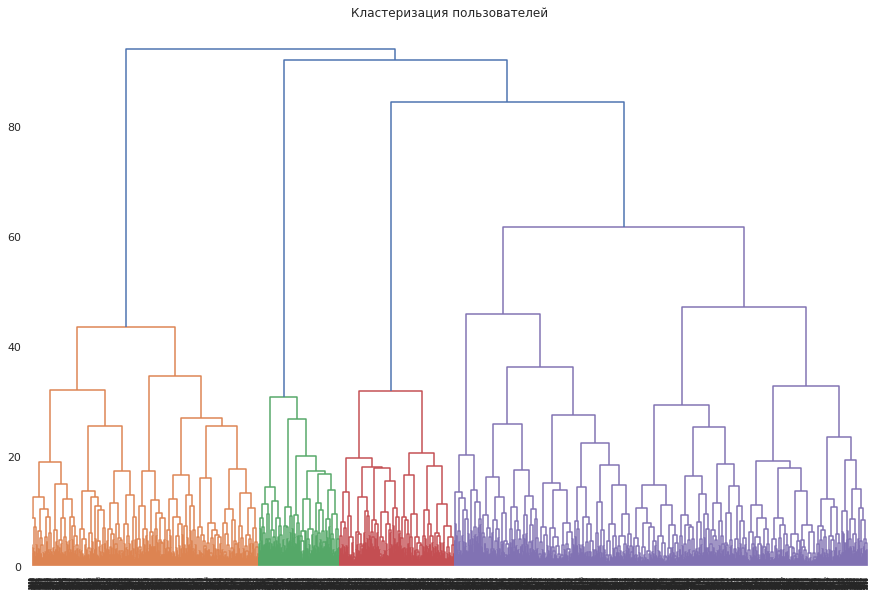

In [27]:
# рисуем дендрограмму
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей')
plt.show() 

По дендрограмме видим 4 кластера, при том последний визуально больше всех. По ТЗ у нас 5 кластеров, будем работать с ними

In [28]:
km = KMeans(n_clusters=5, random_state=0) # задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров 

In [29]:
# сохраняем метки кластера в поле нашего датасета
data_clean['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
data_clean.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
gender,0.50,0.52,0.53,0.50,0.50
near_location,1.00,0.86,1.00,0.00,1.00
partner,0.89,0.47,0.42,0.49,0.19
promo_friends,1.00,0.31,0.01,0.08,0.06
phone,1.00,0.00,1.00,1.00,1.00
contract_period,6.87,4.78,6.72,2.98,1.94
group_visits,0.52,0.43,0.55,0.23,0.29
age,29.52,29.30,30.80,28.70,27.79
avg_additional_charges_total,151.92,144.21,175.87,137.54,124.96
lifetime,4.20,3.94,5.61,2.99,2.09


Если разделить пользователей на 5 кластеров, получаем следующее:

* пол и возраст в среднем по всем кластерам приблизительно одинаковый

* кластеры условно можно назвать по признакам:
    * 0 - приверженцы. Имеют "долгие" на 12 мес абонементы, почти все - 94% живут рядом, тратят больше всех денег на дополнительные услуги, больше всех ходят на групповые занятия, вторая позиция по числу партнеров компании и больше всех из пришедших по акции
    * 1 - любители тишины. Единственный кластер, который не оставил номер телефона. 31% пришел по акции, 47% - партнеры. Больше ничем особенно не выделются
    * 2 - мимокрокодилы. Дальше всех живут, только 72% находятся рядом, реже всех прихоят по акции - только 2%, "берут короткие" абонементы и "живут" 2,2 месяца. Меньше всех тратят на доп.услуги
    * 3 - спортстмены. Самая маленькая доля партнеров 26%, редко приходят по акции - 5%, покупают короткие абонементы, но имеют лайфтайм даже больше, чем приверженцы. Вторая позиция по тратам на допы. Имеют самое большое количество тренировок в неделю
    * 4 - товарищи. Ближе всех находятся - 95%, самый большой процент партнеров - 83%, все пришли по акции "Приведи друга"

* меньше всех отваливаются пользователи приверженцы и спортсмены

* чаще всех отваливаются мимокрокодилы

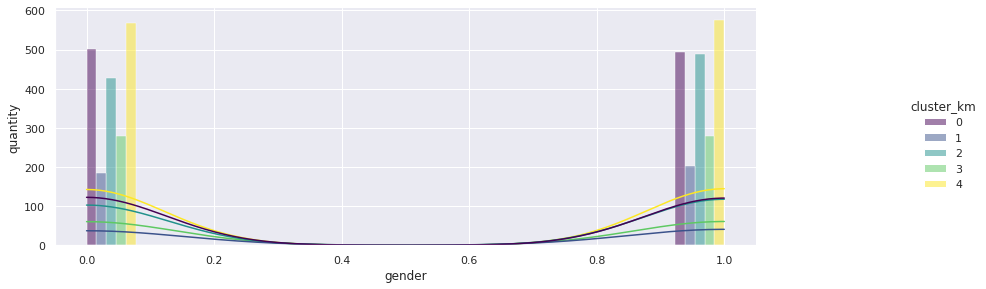

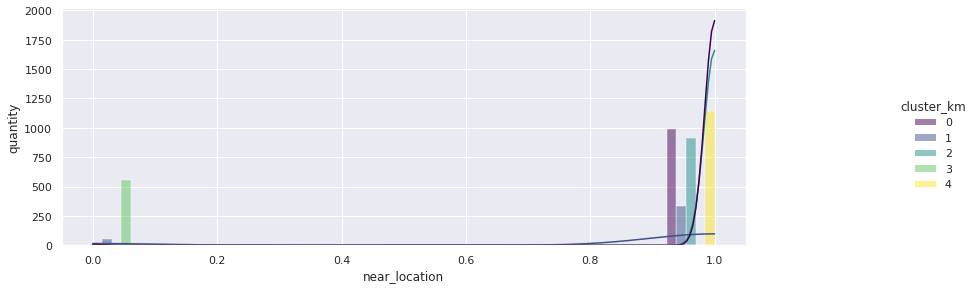

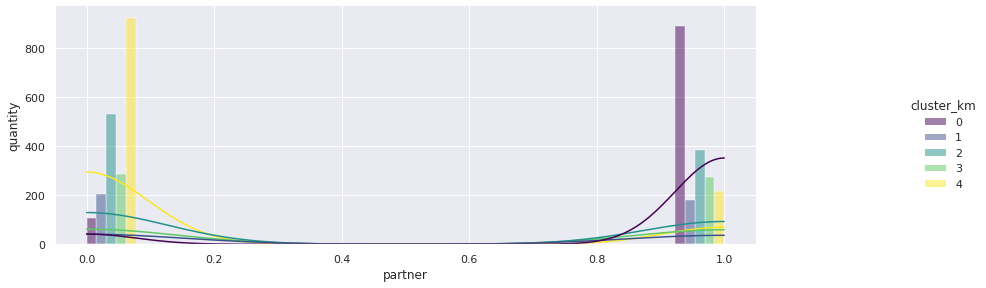

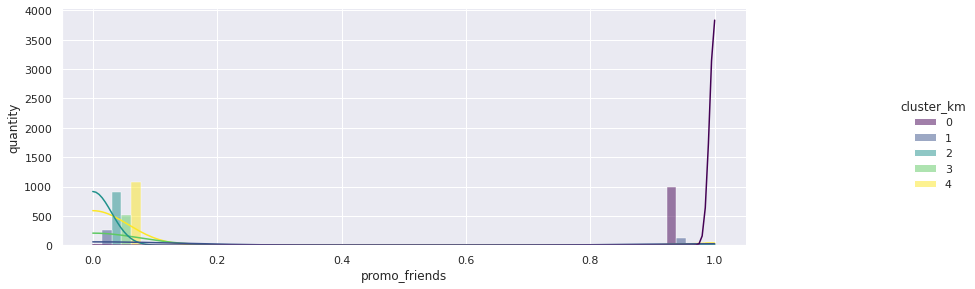

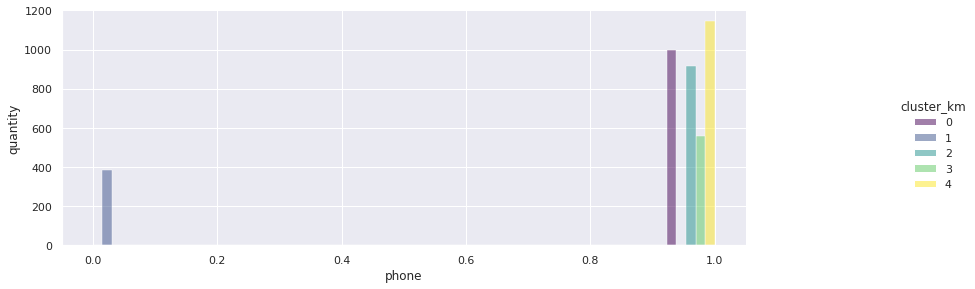

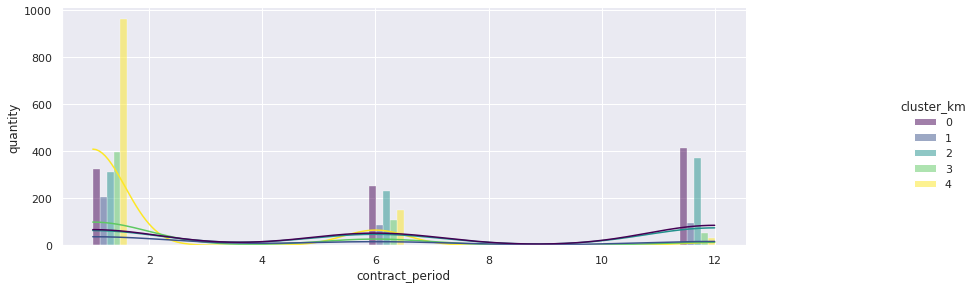

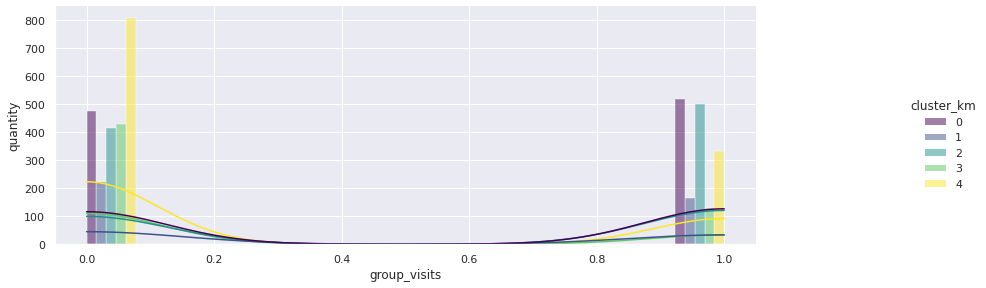

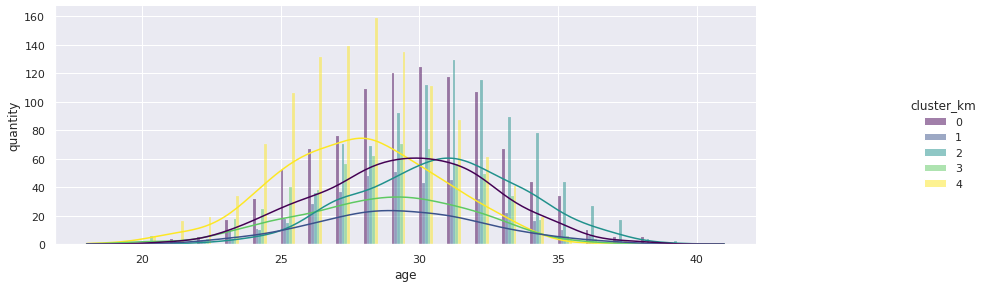

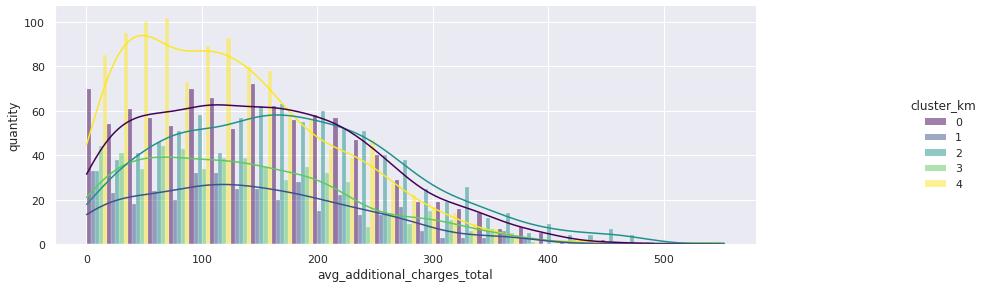

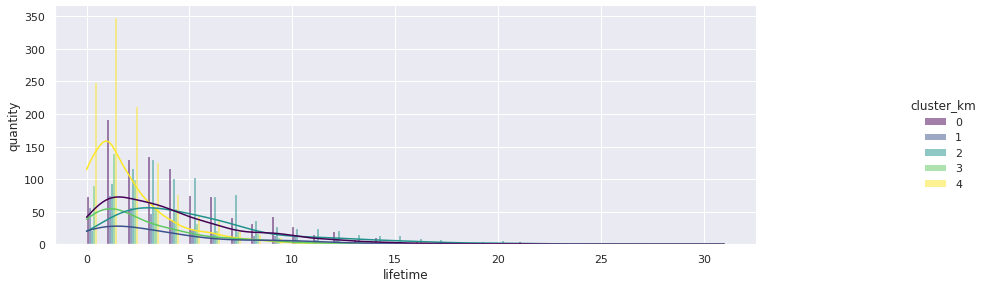

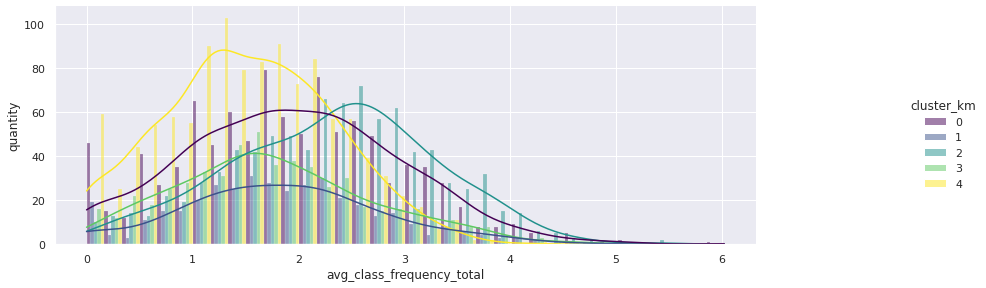

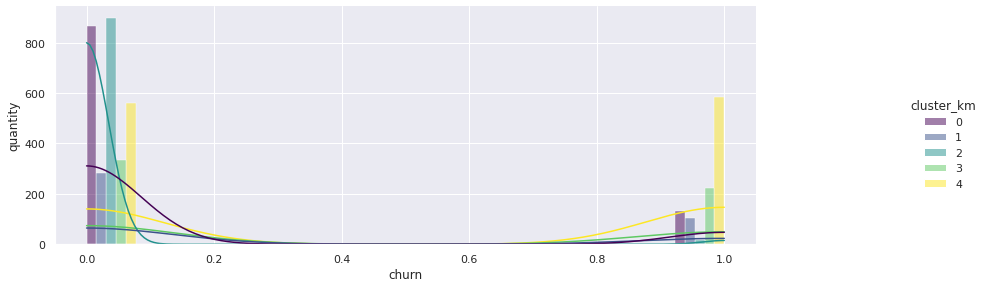

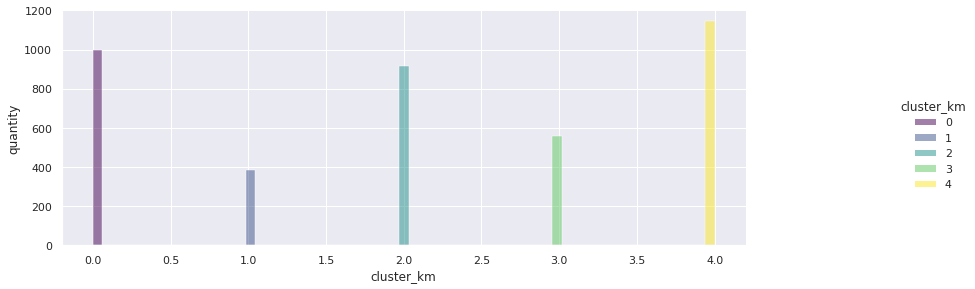

In [30]:
# рисуем гистограммы

for name in data_clean:
    g = sns.displot(data_clean, x=name, hue="cluster_km", palette="viridis", multiple="dodge", kde=True)
    g.fig.set_figwidth(15)
    g.fig.set_figheight(4)
    g.set_axis_labels(name, "quantity")
    g.set_titles("{col_name}");
    plt.show()

Вывод

* распределение по полу примерно одинаково во всех 5 кластерах, только в кластере 3 есть видимые различия
* признак проживания или работы рядом с фитнес-центром наименее характерен для 1 кластера
* клиент является сотрудником компаний-партнеров - этот признак явно выражен в 0 и 4 кластере, а вот клиенты из 2 и 3 кластеров практически таковыми сотрудниками не являются;
* промоакция на первую покупку абонемента успешно работает 4 кластере, а в кластерах 2 и 3 ситуация обратная, в кластре 0 одинаково
* клиенты всех кластеров, за исключением 1, оставили свой контактный номер телефона
* длительность текущего абонемента - клиенты из 2, 3, и 4 кластера покупаю чаще всего абонемент на 1 месяц, клиенты 0 кластера выбираю более долгосрочные абонементы (12 месяцев). Полугодовые абонементы во всех кластерах одинаково плохо востребованы, но у 0 меньше всех
* групповые занятия вотребованы у клиентов 0 кластера, а вот клиенты из кластера 2 практически на них не ходят

* возраст по всем кластерам примерно одинаковый от 25 до 35 лет, но можно сказать, что аудитория 1 и 4 кластеров более возрастная, а 2 - более молодая
* суммарная выручка от прочих услуг меньше всего у клиентов из 2 кластера, больше всего склонны тратить клиенты 0 и 3 кластеров
* лайфтайм (с момента первого обращения в фитнес-центр) самый короткий у 2 кластера.
* средняя частота посещений в неделю за месяц больше всего у клиентов 1 кластера, реже всего посещают клиенты 2 кластера

* клиенты 2 кластера составляют самую многочисленную группу, на последнем месте по численности - 1 кластер
* наибольшее количество оттока во 2 кластере, наименьшее в 0 и 3 кластерах

In [32]:
# вывод доли оттока клиентов для кластеров
data_clean.groupby('cluster_km', as_index=False)['churn'].mean().style.background_gradient('Blues', subset='churn')

,cluster_km,churn
0,0,0.132530
1,1,0.266839
2,2,0.018559
3,3,0.401434
4,4,0.511364


Больше всех отваливается кластер 2, меньше всех 0 и 3

## Выводы и базовые рекомендации по работе с клиентами

**Выводы**

1. Загрузили и изучили дата-сет. Исправили заголовки в смешаном регистре и числа с плавающей точкой, где можно применить целые. Дата-сет из 4000 наблюдений по 13 признакам с одной ключевой переменной(churn). Выбросов, пропусков и явных дубликатов не обнаружено.

2. Произвели исследовательский анализ данных (EDA). Изучили средние значения и стандартные отклонения признаков (в том числе и в разрезе групп). Получены следующие результаты:

    * распределение по полу примерно одинаково 
    * большинство клиентов (84.5%) живет или работает рядом с фитнес-клубом
    * примерно половина клиентов являются сотрудниками партнерских организаций
    * около 30% клиентов пришли по программе "Приведи друга"
    * известны мобильные номера примерно 90% клиентов
    * средняя длительность абонемента клиентов - 4.6 месяца
    * чуть более 40% клиентов посещают групповые занятия
    * средний возраст клиентов 29 лет
    * средние дополнительные расходы на клиента - 146.9 денег (наибольний разброс в данных, стандартное отклонение 96.35)
    * средний срок до окончания договора - 4.3 месяца
    * среднее время с момента первого обращения в фитнес-центр - 3.7 месяца
    * средняя частота посещений за все время - 1.87 раз в неделю
    * средняя частота посещений за последний месяц - 1.76 раз в неделю
    * **доля оттока - 26.5%**
    
Для отскочивших клиентов характерны краткосрочные абонементы, слабое посещение групповых занятий. Таким клиентам около 26 лет, они не участвуют в промоакциях фитнес-центра и не работают в компаниях-партнерах. В среднем, они посещают фитнес-центр 1 раз в неделю-две недели. Некоторые приобрели абонемент на месяц и ни разу не пришли.
Построили матрицу корреляций, нашли два столбца ведущих к мультиколлинеарности и удалили их. Также рассмотрели зависимости между оттоком и  текущим абонементом, возрастом, сроком окончания абонемента, лайфтаймом, средней частотой посещений в неделю.
    
3. Обучили две модели с неплохой точностью и выбрали лучшую. Теперь мы можем прогнозировать вероятность оттока по каждому клиенту. Явных зависимостей факта оттока от одного конкретного признака из рассматриваемых не обнаружено.

4. Стандартизировали данные и кластеризировали клиентов. Построили дендрограмму, которая показала 4 кластера. По ТЗ использовали 5 кластеров и применили алгоритм K-means к имеющимся пользователям. Получили следующие группы:
    * 0 - приверженцы. Имеют "долгие" на 12 мес абонементы, почти все - 94% живут рядом, тратят больше всех денег на дополнительные услуги, больше всех ходят на групповые занятия, вторая позиция по числу партнеров компании и больше всех из пришедших по акции
    * 1 - любители тишины. Единственный кластер, который не оставил номер телефона. 31% пришел по акции, 47% - партнеры. Больше ничем особенно не выделются
    * 2 - мимокрокодилы. Дальше всех живут, только 72% находятся рядом, реже всех прихоят по акции - только 2%, "берут короткие" абонементы и "живут" 2,2 месяца. Меньше всех тратят на доп.услуги
    * 3 - спортстмены. Самая маленькая доля партнеров 26%, редко приходят по акции - 5%, покупают короткие абонементы, но имеют лайфтайм даже больше, чем приверженцы. Вторая позиция по тратам на допы. Имеют самое большое количество тренировок в неделю
    * 4 - товарищи. Ближе всех находятся - 95%, самый большой процент партнеров - 83%, все пришли по акции "Приведи друга"
Посчитали доли оттока для кластеров и выявили: кластеры 0 и 3 надежны, кластер 2 склонен к оттоку, хотя и самый большой.

**Рекомендации**

* Популяризация групповых занятий: уточнить причины слабой посещаемости их (не более 55% в самом посещающем кластере) и корректировать их. Возможна акция на первую бесплатную групповую тренировку.
* Добавить краткосрочных абонементов, например, на три месяца. Некоторые люди берут абонемент на месяц и ни разу не приходят.
* Установление более выгодных цен на средние абонементы.
* Расширить акцию *Приведи друга* и давать бонусы за привод друга 3 месяца занятий бесплатно, если друг останется более 3 месяцев.
* Поскольку люди чаще всего бросают занятия фитнесом в первый месяц, можно придумать стратегии стимуляции интереса клиента продолжать посещать зал - например, после 5 посещений занятий в фитнес центре предлагать бесплатную процедуру массажа.